# Activation Function Characterization

This notebook characterizes the electro-optic activation function. *Some* of these results are presented as the initial figures of the paper.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../neuroptica")
import time
import neuroptica as neu
import numpy as np
import scipy
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import *

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

---

## Characterization of push-pull vs push

Here we compare the activation when the MZI is used in "push-pull" and "push" configuration. Based on the plot below, the conclusions are

* Both **push-pull** and **push-** configurations have the same amplitude response
* The **push-** configuration has a residual nonlinear phase response is observed (ala SPM) 
* The **push-pull** configuration surpresses the nonlinear phase shift


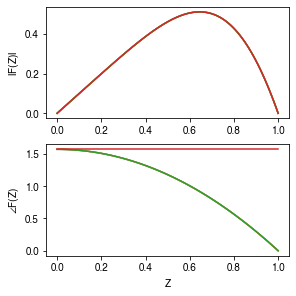

In [2]:
def _F(theta1, theta2):
    return 0.5 * 1j * (np.exp(-1j*theta1) + np.exp(-1j*theta2))

def F_pushpull(Z, gain=np.pi, bias=0):
    theta = gain*np.abs(Z)**2 + bias
    return _F(-theta/2, +theta/2)*Z

def F_push(Z, gain=np.pi, bias=0):
    theta = gain*np.abs(Z)**2 + bias
    return _F(theta, 0)*Z

def F_push_alt(Z, gain=np.pi, bias=0):
    theta = gain*np.abs(Z)**2 + bias
    return 1j*np.exp(-1j*theta/2)*np.cos(theta/2)*Z

def F_neuroptica(Z, gain=np.pi, bias=0):
    eo_setting = { 'alpha':         0.0,
                    'responsivity': 0.80,
                    'V_pi':         15.0,
                    'V_bias':       15.0,
                    'R':            5e4 }
    eoa = neu.nonlinearities.ElectroOpticActivation(1, **eo_setting)
    eoa.g = gain
    eoa.phi_b = bias
    return eoa.forward_pass(Z)

Fs = [F_push, F_push_alt, F_neuroptica, F_pushpull]

gain = np.pi
bias = 0

Z = np.linspace(1e-6,1.0,99)

fig, axs = plt.subplots(2, 1, figsize=(4,4), constrained_layout=True)
for F in Fs:
    axs[0].plot(Z, np.abs(F(Z, gain=gain, bias=bias)))
    axs[1].plot(Z, np.angle(F(Z, gain=gain, bias=bias)))
    
axs[0].set_ylabel(r"$\vert F(Z) \vert$")
axs[1].set_ylabel(r"$\angle F(Z)$")
axs[1].set_xlabel(r"$Z$")
fig.align_labels()

## Activation input-output and transmission

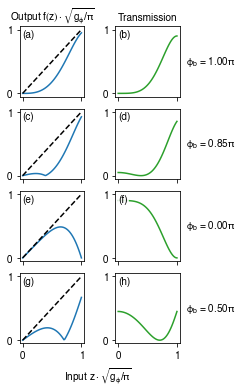

In [3]:
eo_settings = []
for phi_b in [-1.00, 0.85, 0.00, 0.5]:
    eo_settings.append(
                  { 'alpha': 0.1,
                    'g':     np.pi,
                    'phi_b': phi_b*np.pi } )

eoa = neu.nonlinearities.ElectroOpticActivation(1, **eo_settings[0])

X = np.linspace(1e-6, 1.0, 75)

fig, axs = plt.subplots(len(eo_settings), 2, figsize=(3.25,5), constrained_layout=True, sharex=True)
axL = axs[:,1].ravel()
axR = axs[:,0].ravel()

for i, eo_setting in enumerate(eo_settings):
    eoa = neu.nonlinearities.ElectroOpticActivation(1, **eo_setting)
    Fx = eoa.forward_pass(X)
    t = np.abs(Fx)/np.abs(X)
    T = t**2
    dT = np.abs(T-T[0])
    
    X_vec = X*np.sqrt(eoa.g/np.pi)
    
    ind_th = np.argmin(np.abs(dT-0.5))
    X_th = X[ind_th]
    axL[i].plot(X_vec, T, "-", c="#2ca02c")
    axL[i].set_ylim([-0.05,1.05])
    axL[i].set_xlim([-0.05,1.05])
    axL[i].set_xticks(np.linspace(0,1,2))
    axL[i].set_yticks(np.linspace(0,1,2))
    
    axR[i].plot(X_vec, np.abs(Fx)*np.sqrt(eoa.g/np.pi), "-")
    axR[i].plot(X_vec, X*np.sqrt(eoa.g/np.pi), 'k--')  
    axR[i].set_ylim([-0.05,1.05])
    axR[i].set_xlim([-0.05,1.05])
    axR[i].set_xticks(np.linspace(0,1,2))
    axR[i].set_yticks(np.linspace(0,1,2))
    
#     axR[i].annotate(r"$\phi_b$ = %.2f$\pi$" % (eoa.phi_b/np.pi), xy=(0.5,0.5), xycoords="axes fraction", ha="center", va="center")
    axL[i].text(1.15, 0.5, r"$\phi_b$ = %.2f$\pi$" % (np.abs(eoa.phi_b/np.pi)), ha="left", va="center")
    
axR[0].set_title(r'Output $f{\left(z\right)}\cdot\sqrt{g_\phi/\pi}$')
axL[0].set_title('Transmission')

fig.text(0.4, -0.045, "Input $z\cdot\sqrt{g_\phi/\pi}$", ha='center')

apply_sublabels(axs.ravel(), y=-3, x=3, prefix="(", postfix=")", ha='left', va='top', weight='normal', bg="w")

## Activation function power calibration

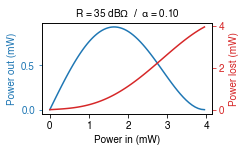

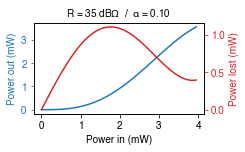

In [4]:
def calc_Xmax(eoa):
    return np.sqrt(np.pi/eoa.g)

def norm_power(X, A=1e-12, eta=120*np.pi):
    return 0.5 * A * np.sum( np.square( np.abs(X) ) ) / eta
    
def do_calibration(V_bias=10.0, X_max=1.0, c_out="#1f77b4", c_lost="#d62728", V_pi=5, R=1e5, alpha=0.1, plt_loss=False):
    N = 1
    eo_settings = { 'alpha':        alpha,
                    'responsivity': 0.80, # A/W
                    'V_pi':         V_pi, # Volts
                    'V_bias':       V_bias,  # Volts
                    'R':            R } # Ohms

    model = neu.Sequential([
        neu.nonlinearities.ElectroOpticActivation(N, **eo_settings)
    ])
    eoa = model.layers[-1]
        
    X  = np.linspace(1e-3,X_max,99)*calc_Xmax(eoa)

    L  = np.zeros(X.size);
    P0 = np.zeros(X.size);
    P1 = np.zeros(X.size);

    for i, X0 in enumerate(X):
        X0    = X0*np.ones((N,1))
        X1    = model.forward_pass(X0)
        P0[i] = norm_power(X0)
        P1[i] = norm_power(X1)
        L[i]  = 1-P1[i]/P0[i]

    fig, ax1 = plt.subplots(1, 1, figsize=(3.3,2), constrained_layout=True)
    
    if plt_loss:
        ax2 = ax1.twinx()
        ax2.plot(P0/1e-3, L*P0/1e-3, color=c_lost)
        ax2.set_ylabel(r"Power lost (mW)", color=c_lost)
        ax2.tick_params("y", colors=c_lost)
    
    ax1.plot(P0/1e-3, P1/1e-3, color=c_out)
    ax1.set_xlabel(r"Power in (mW)")
    ax1.set_ylabel(r"Power out (mW)", color=c_out)
    ax1.tick_params("y", colors=c_out)
    
    ax1.set_title("$R$ = %.0f dB$\Omega$  /  $\\alpha$ = %.2f" % (10*np.log10(R), alpha))
    fig.align_labels()

do_calibration(V_bias=0, X_max=1.0, alpha=0.1, V_pi=1, R=10**(35/10), plt_loss=True)
do_calibration(V_bias=5, X_max=1.0, alpha=0.1, V_pi=1, R=10**(35/10), plt_loss=True)

## Activation function threshold

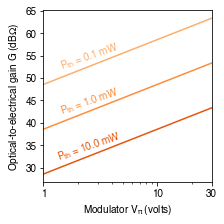

In [5]:
Pth_vec = [0.1e-3, 1e-3, 10e-3]
colors = ["#fdae6b", "#fd8d3c", "#e6550d"]

def calc_G_Pth(Pth, Vpi, alpha=0.1, R=1.0):
    return 0.72 * Vpi  / alpha / R / Pth

Vpi = np.linspace(1,30,20)

fig, ax = plt.subplots(1, 1, figsize=(3,3), constrained_layout=True, sharey=False)

for i, Pth in enumerate(Pth_vec):
    G = calc_G_Pth(Pth, Vpi)
    G = 10*np.log10(G)
    ax.semilogx(Vpi, G, c=colors[i])
    ax.annotate("$P_{th}$ = %.1f mW" % (Pth/1e-3), xy=(Vpi[1], G[1]),
                 xytext=(0,10), textcoords="offset points", color=colors[i],
                ha="center", va="center", rotation=19)

ax.set_xlabel("Modulator $V_\pi$ (volts)")
ax.set_ylabel("Optical-to-electrical gain $G$ (dB$\mathsf{\Omega}$)")
ax.set_xticks([1,10,30])
ax.set_xticklabels(["1","10","30"])
ax.set_xlim([1,30]);

## Comparison to Kerr nonlinearity

Here we generate the figure to compare the feedforward nonlinear phase with an all-optical Kerr nonlinear phase.

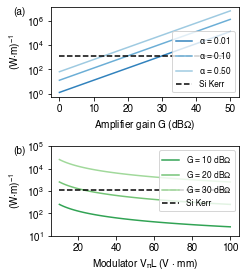

In [6]:
def gamma_eo_ff(R, vpi_L, alpha, responsivity=0.8):
    '''
    Calculate the effective nonlinear parameter for the electro-optic feed
    forward scheme. \gamma is interpreted as the accumulated phase per unit
    input power per unit length
    :param R:      the feedforward transimpedance gain [Ohms] 
    :param vpiL:   modulator Vpi*L product [V*meters]
    :param alpha:  tapped off optical power [unitless]
    '''
    
    return alpha * np.pi * R * responsivity / vpi_L

def gamma_kerr(n2, A=1, lambda0=1550e-9):
    '''
    Calculate the nonlinear parameter for a Kerr waveguide
    :param n2:      Nonlinear refractive index [m^2/Watt]
    :param A:       Effective waveguide mode area [um^2]
    :param lambda0: Free space wavelength
    '''
    
    A = A* 1e-12
    return 2*np.pi*n2/lambda0/A

R = np.logspace(0,5,19)
vpi_L = 20e-3

fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(3.3,3.75), constrained_layout=True, sharey=False)

ind = 1

bbox_props = dict(boxstyle="square,pad=0.0", fc="w", ec="none", alpha=0.75)

cs = ["#3182bd", "#6baed6", "#9ecae1", "#c6dbef"]
for i, alpha in enumerate([0.01, 0.10, 0.5]):
    gammai = gamma_eo_ff(R, vpi_L, alpha)
    ax0.semilogy(10*np.log10(R), gammai, "-", c=cs[i], label="$\\alpha$ = %.2f" % alpha)
#     ax0.annotate("$\\alpha$ = %.2f" % alpha, xy=(0, 10**3.5),
#                  xytext=(0,10*i), textcoords="offset points", color=cs[i],ha="left")

gam = gamma_kerr(14e-18, A = 0.05)
l0, = ax0.semilogy(10*np.log10([R.min(), R.max()]), np.ones(2)*gam,"k--", label="Si Kerr")

# ax0.annotate("Kerr (Si)", xy=(10*np.log10(R.max()), gam),
#              xytext=(0,-12.5), textcoords="offset points", ha="right")

# ax0.fill_between(10*np.log10([R.min(), R.max()]), np.ones(2)*gam, np.ones(2)*1e8, facecolor="#cccccc", alpha=0.45 )

ax0.set_xlabel("Amplifier gain $G$ (dB$\mathsf{\Omega}$)");
ax0.set_ylabel("(W$\cdot$m)$^{-1}$");

# -------------------------------------

cs = ["#31a354", "#74c476", "#a1d99b"]
alpha = 0.1
vpi_L = np.linspace(10e-3, 100e-3, 99)

for i, R in enumerate([1e1, 1e2, 1e3]):
    gammai = gamma_eo_ff(R, vpi_L, alpha)
    ax1.semilogy(vpi_L/1e-3, gammai, "-", c=cs[i], label="$G$ = %.0f dB$\mathsf{\Omega}$" % (10*np.log10(R)))
#     ax1.annotate("$G$ = %.0f dB$\mathsf{\Omega}$" % (10*np.log10(R)), xy=(90, 10**3.2),
#                   xytext=(0,10*i), textcoords="offset points", color=cs[i],ha="right", bbox=bbox_props)

gam = gamma_kerr(14e-18, A = 0.05)
l0, = ax1.semilogy(np.array([vpi_L.min(), vpi_L.max()])/1e-3, np.ones(2)*gam,"k--", label="Si Kerr")
# ax1.fill_between(np.array([vpi_L.min(), vpi_L.max()])/1e-3, np.ones(2)*gam, np.ones(2)*1e8, facecolor="#cccccc", alpha=0.45 )

ax1.set_xlabel("Modulator $V_\pi L$ (V $\cdot$ mm)");
ax1.set_ylabel("(W$\cdot$m)$^{-1}$");
ax1.set_ylim([1e1,1e5])
ax0.set_yticks([1e0, 1e2, 1e4, 1e6])
ax1.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5])

ax0.legend(fontsize="smaller")
ax1.legend(fontsize="smaller")

apply_sublabels([ax0, ax1], x=-25, prefix="(", postfix=")", weight="normal")

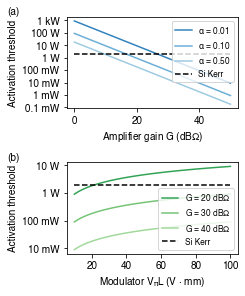

In [7]:
def gamma_eo_ff(R, vpi_L, alpha, responsivity=0.8):
    '''
    Calculate the effective nonlinear parameter for the electro-optic feed
    forward scheme. \gamma is interpreted as the accumulated phase per unit
    input power per unit length
    :param R:      the feedforward transimpedance gain [Ohms] 
    :param vpiL:   modulator Vpi*L product [V*meters]
    :param alpha:  tapped off optical power [unitless]
    '''
    
    return alpha * np.pi * R * responsivity / vpi_L

def gamma_kerr(n2, A=1, lambda0=1550e-9):
    '''
    Calculate the nonlinear parameter for a Kerr waveguide
    :param n2:      Nonlinear refractive index [m^2/Watt]
    :param A:       Effective waveguide mode area [um^2]
    :param lambda0: Free space wavelength
    '''
    
    A = A* 1e-12
    return 2*np.pi*n2/lambda0/A

def Pth_gamma(gamma, L):
    return 0.72*np.pi / gamma / L

R = np.logspace(0,5,19)
vpi_L = 10e-3

fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(3.3,4), constrained_layout=True, sharey=False)

ind = 1

bbox_props = dict(boxstyle="square,pad=0.0", fc="w", ec="none", alpha=0.75)

cs = ["#3182bd", "#6baed6", "#9ecae1", "#c6dbef"]
for i, alpha in enumerate([0.01, 0.10, 0.5]):
    gammai = gamma_eo_ff(R, vpi_L, alpha)
    ax0.semilogy(10*np.log10(R), Pth_gamma(gammai, 1000e-6), "-", c=cs[i], label="$\\alpha$ = %.2f" % alpha)
#     ax0.annotate("$\\alpha$ = %.2f" % alpha, xy=(0, 10**3.5),
#                  xytext=(0,10*i), textcoords="offset points", color=cs[i],ha="left")

gam = gamma_kerr(14e-18, A = 0.05)
l0, = ax0.semilogy(10*np.log10([R.min(), R.max()]), np.ones(2)*Pth_gamma(gam, 1000e-6),"k--",label="Si Kerr")

# ax0.annotate("Kerr (Si)", xy=(10*np.log10(R.max()), gam),
#              xytext=(0,-12.5), textcoords="offset points", ha="right")

ax0.set_xlabel("Amplifier gain $G$ (dB$\mathsf{\Omega}$)");
ax0.set_ylabel("Activation threshold");
ax0.legend(fontsize="smaller")

# -------------------------------------

cs = ["#31a354", "#74c476", "#a1d99b"]
alpha = 0.1
vpi_L = np.linspace(10e-3, 100e-3, 99)

for i, R in enumerate([1e2, 1e3, 1e4]):
    gammai = gamma_eo_ff(R, vpi_L, alpha)
    ax1.semilogy(vpi_L/1e-3, Pth_gamma(gammai, 1000e-6), "-", c=cs[i], label="$G$ = %.0f dB$\mathsf{\Omega}$" % (10*np.log10(R)))
#     ax1.annotate("$G$ = %.0f dB$\mathsf{\Omega}$" % (10*np.log10(R)), xy=(90, 10**3.2),
#                   xytext=(0,10*i), textcoords="offset points", color=cs[i],ha="right", bbox=bbox_props)

gam = gamma_kerr(14e-18, A = 0.05)
l0, = ax1.semilogy(np.array([vpi_L.min(), vpi_L.max()])/1e-3, np.ones(2)*Pth_gamma(gam, 1000e-6),"k--", label="Si Kerr")

ax1.set_xlabel("Modulator $V_\pi L$ (V $\cdot$ mm)");
ax1.legend(fontsize="smaller")
ax1.set_ylabel("Activation threshold");

ax0.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
ax0.set_yticklabels(['0.1 mW', '1 mW', '10 mW', '100 mW', '1 W', '10 W', '100 W', '1 kW'])
ax1.set_yticks([1e-2, 1e-1, 1e0, 1e1])
ax1.set_yticklabels(['10 mW', '100 mW', '1 W', '10 W'])

apply_sublabels([ax0, ax1], x=-47, y=10, prefix="(", postfix=")", weight="normal")

fig.align_labels()